## DeepLearning on notMNIST Dataset

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be resuing later.

This notebook uses the notMNIST dataset. This dataset is designed to look like the classic MNIST dataset, while looking more like real data. It is supposively harder task as the data is less 'clean' than MNIST

In [8]:
# Importing modules
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

1. Download the **notMNIST** dataset to our local machine.
2. The dataset consists of characters rendered in a variety of fonts on a 28x28 image.
3. The labels are limited to 'A' through 'J' (10 classes). 
4. Training examples = 500,000 & Test examples = 19,000

In [9]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = './datasets/' # where to store data

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename)
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception(
            'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)
        

Found and verified ./datasets/notMNIST_large.tar.gz
Found and verified ./datasets/notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file. This should give you a set of directories, labeled **A** through **J**.

In [11]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0] #remove .tar.gz
    if os.path.isdir(root) and not force:
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception(
            'Expected %d folder, one per class. Found %d instead.' % 
                (num_classes, len(data_folders)))
    print(data_folders)
    return data_folders

train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)
    

./datasets/notMNIST_large already present - Skipping extraction of ./datasets/notMNIST_large.tar.gz.
['./datasets/notMNIST_large/A', './datasets/notMNIST_large/B', './datasets/notMNIST_large/C', './datasets/notMNIST_large/D', './datasets/notMNIST_large/E', './datasets/notMNIST_large/F', './datasets/notMNIST_large/G', './datasets/notMNIST_large/H', './datasets/notMNIST_large/I', './datasets/notMNIST_large/J']
./datasets/notMNIST_small already present - Skipping extraction of ./datasets/notMNIST_small.tar.gz.
['./datasets/notMNIST_small/A', './datasets/notMNIST_small/B', './datasets/notMNIST_small/C', './datasets/notMNIST_small/D', './datasets/notMNIST_small/E', './datasets/notMNIST_small/F', './datasets/notMNIST_small/G', './datasets/notMNIST_small/H', './datasets/notMNIST_small/I', './datasets/notMNIST_small/J']


#### Problem1 
Let's take a peek at some of the data to make sure it looks sensible. Each example should be an image of a character **A** throught **J** rendered in a different font. Display a sample of the images that we just downloaded. 
*Hint: Possibly use IPython.display*

In [12]:
import random

def disp_samples(data_folders, sample_size):
    for folder in data_folders:
        print(folder)
        image_files = os.listdir(folder)
        image_sample = random.sample(image_files, sample_size)
        for image in image_sample:
            image_file = os.path.join(folder, image)
            i = Image(filename=image_file)
            display(i)

In [16]:
disp_samples(train_folders, 1)

./datasets/notMNIST_large/A


./datasets/notMNIST_large/B


./datasets/notMNIST_large/C


./datasets/notMNIST_large/D


./datasets/notMNIST_large/E


./datasets/notMNIST_large/F


./datasets/notMNIST_large/G


./datasets/notMNIST_large/H


./datasets/notMNIST_large/I


./datasets/notMNIST_large/J


In [19]:
disp_samples(test_folders, 2)

./datasets/notMNIST_small/A


./datasets/notMNIST_small/B


./datasets/notMNIST_small/C


./datasets/notMNIST_small/D


./datasets/notMNIST_small/E


./datasets/notMNIST_small/F


./datasets/notMNIST_small/G


./datasets/notMNIST_small/H


./datasets/notMNIST_small/I


./datasets/notMNIST_small/J


Now let's load the data in more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

We'll skip unreadable images. 

In [20]:
image_size = 28 # Pixel width and height
pixel_depth = 255.0 # Number of levels per pixel

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    # create an empty n-Dim array of size of image and pre-defined
    # data type
    dataset = np.ndarray(shape=(len(image_files), image_size, 
                         image_size), dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (ndimage.imread(image_file).astype(float)
                            - pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' 
                                   % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
        
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d'
                           % (num_images, min_num_images))
        
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset

def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - skipping pickling.' 
                     % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
        
    return dataset_names    

In [22]:
train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling ./datasets/notMNIST_small/A.pickle.
./datasets/notMNIST_small/A
Could not read: ./datasets/notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png : cannot identify image file './datasets/notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png' - it's ok, skipping.
Full dataset tensor: (1872, 28, 28)
Mean: -0.132626
Standard deviation: 0.445128
Pickling ./datasets/notMNIST_small/B.pickle.
./datasets/notMNIST_small/B
Full dataset tensor: (1873, 28, 28)
Mean: 0.00535609
Standard deviation: 0.457115
Pickling ./datasets/notMNIST_small/C.pickle.
./datasets/notMNIST_small/C
Full dataset tensor: (1873, 28, 28)
Mean: -0.141521
Standard deviation: 0.44269
Pickling ./datasets/notMNIST_small/D.pickle.
./datasets/notMNIST_small/D
Full dataset tensor: (1873, 28, 28)
Mean: -0.0492167
Standard deviation: 0.459759
Pickling ./datasets/notMNIST_small/E.pickle.
./datasets/notMNIST_small/E
Full dataset tensor: (1873, 28, 28)
Mean: -0.0599148
Standard deviation: 0.45735
Picklin

#### Problem 2
Let's cross-check the data to make sure it looks correct. We can display a sample of the labels and images from the ndarray. *Hint: we can use matplotlib.pyplot*

In [36]:
# A_list = pickle.load(open("./datasets/notMNIST_large/A.pickle", "rb"))
# random_letter = random.choice(A_list)
# plt.imshow(random_letter)
# plt.axis('off')

def disp_sample_pickles(data_folders):
    folder = random.sample(data_folders, 1)
    pickle_filename = ''.join(folder) + '.pickle'
    try:
        with open(pickle_filename, 'rb') as f:
            dataset = pickle.load(f)
    except Exception as e:
        print('Unable to read data from', pickle_filename, ':', e)
        return
    
    # display
    """Display subplot with 8 images or less"""
    plt.suptitle(''.join(folder)[-1])
    for i, img in enumerate(random.sample(list(dataset), 8)):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.imshow(img)

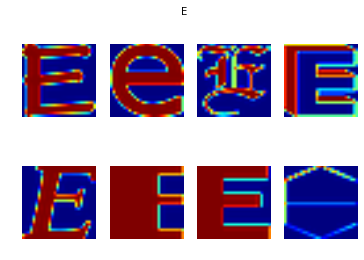

In [39]:
disp_sample_pickles(train_folders)

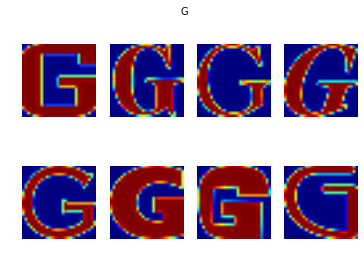

In [41]:
disp_sample_pickles(test_folders)

### Problem 3
Another check: we expect the data to be balanced across classes. Verify that.

Data is balanced across classes if the classes have about the same number of items. Let's check number of images per training and test classes.

In [42]:
def disp_number_images(data_folders):
    for folder in data_folders:
        pickle_filename = ''.join(folder) + '.pickle'
        try:
            with open(pickle_filename, 'rb') as f:
                dataset = pickle.load(f)
        except Exception as e:
            print('Unable to read data from', pickle_filename, ':', e)
            return
        print('Number of images in ', folder, ' : ', len(dataset))

In [43]:
disp_number_images(train_folders)

Number of images in  ./datasets/notMNIST_large/A  :  52909
Number of images in  ./datasets/notMNIST_large/B  :  52911
Number of images in  ./datasets/notMNIST_large/C  :  52912
Number of images in  ./datasets/notMNIST_large/D  :  52911
Number of images in  ./datasets/notMNIST_large/E  :  52912
Number of images in  ./datasets/notMNIST_large/F  :  52912
Number of images in  ./datasets/notMNIST_large/G  :  52912
Number of images in  ./datasets/notMNIST_large/H  :  52912
Number of images in  ./datasets/notMNIST_large/I  :  52912
Number of images in  ./datasets/notMNIST_large/J  :  52911


In [44]:
disp_number_images(test_folders)

Number of images in  ./datasets/notMNIST_small/A  :  1872
Number of images in  ./datasets/notMNIST_small/B  :  1873
Number of images in  ./datasets/notMNIST_small/C  :  1873
Number of images in  ./datasets/notMNIST_small/D  :  1873
Number of images in  ./datasets/notMNIST_small/E  :  1873
Number of images in  ./datasets/notMNIST_small/F  :  1872
Number of images in  ./datasets/notMNIST_small/G  :  1872
Number of images in  ./datasets/notMNIST_small/H  :  1872
Number of images in  ./datasets/notMNIST_small/I  :  1872
Number of images in  ./datasets/notMNIST_small/J  :  1872


From above results, we can confirm that there are only minor differences between items within training and test classes. So we can assume that classes are well balanced. 

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. 
The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [54]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class + tsize_per_class
    
    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # shuffle the letters to have random validation
                # and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class
                
                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
    
    return valid_dataset, valid_labels, train_dataset, train_labels

train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(train_datasets, train_size, valid_size)

_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)
    
print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)


Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)
200000


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [56]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)


### Problem 4
Convince yourself that the data is still good after shuffling...

Let's verify data after merger and randomization. 

In [145]:
letter_labels = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I', 9:'J'}

def disp_sample_dataset(dataset, labels):
    items = random.sample(range(len(labels)), 8)
    for i, item in enumerate(items):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.title(letter_labels[labels[item]])
        plt.imshow(dataset[item])

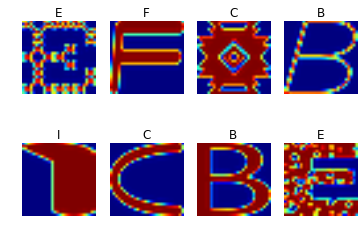

In [146]:
disp_sample_dataset(train_dataset, train_labels)

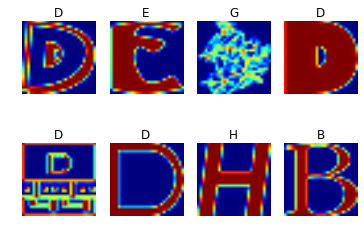

In [147]:
disp_sample_dataset(valid_dataset, valid_labels)

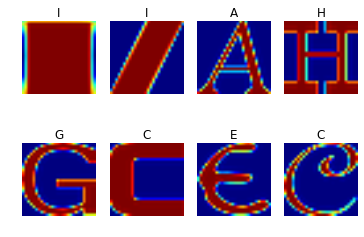

In [148]:
disp_sample_dataset(test_dataset, test_labels)

**Finally let's save the data for later reuse:**

In [61]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise


In [62]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


### Problem 5

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it. Measure how much overlap there is between training, validation and test samples.

Optional questions:
* What about near duplicates between datasets? (images that are almost identical)
* Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.

In this part, I will explore the datasets and understand better the overlap cases. There are overlaps, but there are also duplicates in the same dataset. Processing time is also critical.
* First, will use nested loops and matrix comparison (slow)
* Second, will use hash function to accelerate and process the whole dataset (fast)

In [64]:
def extract_overlap(dataset_1, dataset_2):
    overlap = {}
    for i, img_1 in enumerate(dataset_1):
        for j, img_2 in enumerate(dataset_2):
            if np.array_equal(img_1, img_2):
                if not i in overlap.keys():
                    overlap[i] = []
                overlap[i].append(j)
    return overlap

In [65]:
%time overlap_test_train = extract_overlap(test_dataset[:200], train_dataset)


CPU times: user 2min 40s, sys: 1.12 s, total: 2min 41s
Wall time: 2min 42s


In [66]:
print('Number of overlaps:', len(overlap_test_train.keys()))

Number of overlaps: 25


In [69]:
def display_overlap(overlap, source_dataset, target_dataset):
    item = random.choice(overlap.keys())
    imgs = np.concatenate(([source_dataset[item]], target_dataset[overlap[item][0:7]]))
    plt.suptitle(item)
    for i, img in enumerate(imgs):
        plt.subplot(2,4, i+1)
        plt.axis('off')
        plt.imshow(img)

The display_overlap function display's one of the duplicate, the first element is from the first dataset, and the remaining elements are from the dataset used for the comparison.

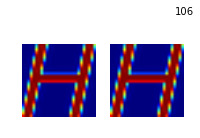

In [78]:
display_overlap(overlap_test_train, test_dataset[:200], train_dataset)

Now that exact duplicates have been found, let's look for near duplicates. How to define near identical images ? 
We will use a Manhattan norm(sum of absolute values) of the difference matrix. 
No normalization needed, since images that are compared are of same size. Comparison done here is pixel-by-pixel comparison.

In [79]:
MAX_MANHATTAN_NORM = 10

def extract_overlap_near(dataset_1, dataset_2):
    overlap = {}
    for i, img_1 in enumerate(dataset_1):
        for j, img_2 in enumerate(dataset_2):
            diff = img_1 - img_2
            m_norm = np.sum(np.abs(diff))
            if m_norm < MAX_MANHATTAN_NORM:
                if not i in overlap.keys():
                    overlap[i] = []
                overlap[i].append(j)
    return overlap

In [80]:
%time overlap_test_train_near = extract_overlap_near(test_dataset[:200], train_dataset)

CPU times: user 4min 47s, sys: 2.33 s, total: 4min 49s
Wall time: 4min 51s


In [81]:
print('Number of near overlaps:', len(overlap_test_train_near.keys()))

Number of near overlaps: 52


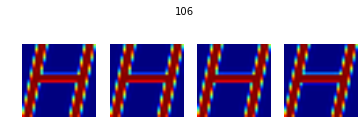

In [86]:
display_overlap(overlap_test_train_near, test_dataset[:200], train_dataset)

To make overlap comparison work at scale for two large datasets, the best option is to use a hash function. 
Using hash function used for the cryptography to find exact duplicates. 

In [90]:
import hashlib

def extract_overlap_hash(dataset_1, dataset_2):
    dataset_hash_1 = [hashlib.sha256(img).hexdigest() for img in dataset_1]
    dataset_hash_2 = [hashlib.sha256(img).hexdigest() for img in dataset_2]
    overlap = {}
    for i, hash1 in enumerate(dataset_hash_1):
        for j, hash2 in enumerate(dataset_hash_2):
            if hash1 == hash2:
                if not i in overlap.keys():
                    overlap[i] = []
                overlap[i].append(j)
    return overlap

In [96]:
%time overlap_test_train = extract_overlap_hash(test_dataset[:1000], train_dataset)

CPU times: user 11.8 s, sys: 46.4 ms, total: 11.9 s
Wall time: 11.9 s


Number of overlaps: 125


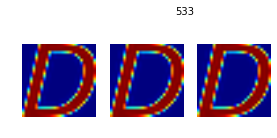

In [98]:
print('Number of overlaps:', len(overlap_test_train.keys()))
display_overlap(overlap_test_train, test_dataset[:1000], train_dataset)

We can make the processing a bit faster by using the built-in numpy *where* function.

In [99]:
def extract_overlap_hash_where(dataset_1, dataset_2):
    dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
    dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
    overlap = {}
    for i, hash1 in enumerate(dataset_hash_1):
        duplicates = np.where(dataset_hash_2 == hash1)
        if len(duplicates[0]):
            overlap[i] = duplicates[0]
    return overlap

In [101]:
%time overlap_test_train = extract_overlap_hash_where(test_dataset[:200], train_dataset)

CPU times: user 3.63 s, sys: 14.5 ms, total: 3.64 s
Wall time: 3.64 s


Number of overlaps: 25


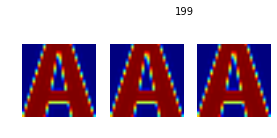

In [133]:
print('Number of overlaps:', len(overlap_test_train.keys()))
display_overlap(overlap_test_train, test_dataset[:200], train_dataset)

To find near duplicates, possible hash functions might be useful:
* Locally sensitive hashing
* perceptual hashing
* difference hashing

Let's generate sanitized datasets without duplicates.

In [134]:
def sanetize(dataset_1, dataset_2, labels_1):
    dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
    dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
    overlap = [] # list of indexes
    for i, hash1 in enumerate(dataset_hash_1):
        duplicates = np.where(dataset_hash_2 == hash1)
        if len(duplicates[0]):
            overlap.append(i)
    return np.delete(dataset_1, overlap, 0), np.delete(labels_1, overlap, None)

In [135]:
%time test_dataset_sanit, test_labels_sanit = sanetize(test_dataset, train_dataset, test_labels)
print('Overlapping images removed: ', len(test_dataset) - len(test_dataset_sanit))
                                                      

CPU times: user 19 s, sys: 897 ms, total: 19.9 s
Wall time: 19.9 s
Overlapping images removed:  1291


In [136]:
%time valid_dataset_sanit, valid_labels_sanit = sanetize(valid_dataset, train_dataset, valid_labels)
print('Overlapping images removed: ', len(valid_dataset) - len(valid_dataset_sanit))

CPU times: user 19.3 s, sys: 163 ms, total: 19.5 s
Wall time: 19.5 s
Overlapping images removed:  1104


In [137]:
pickle_file_sanit = 'notMNIST_sanit.pickle'

try:
  f = open(pickle_file_sanit, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset_sanit,
    'valid_labels': valid_labels_sanit,
    'test_dataset': test_dataset_sanit,
    'test_labels': test_labels_sanit,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [139]:
statinfo = os.stat(pickle_file_sanit)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 683280141


### Problem 6
Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. 
*Hint: you can use the LogisticRegression model from sklearn.linear_model.*

Optional question: train an off-the-shelf model on all the data.

In [143]:
# Using LogisticRegression model
regr = LogisticRegression()
X_test = test_dataset_sanit.reshape(test_dataset_sanit.shape[0], 28*28)
y_test = test_labels_sanit

In [156]:
sample_size = 5000
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]
%time regr.fit(X_train, y_train)
regr.score(X_test, y_test)

CPU times: user 15.9 s, sys: 41.8 ms, total: 16 s
Wall time: 16 s


0.83396486393386149

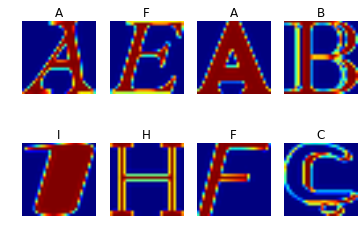

In [158]:
pred_labels = regr.predict(X_test)
disp_sample_dataset(test_dataset_sanit, pred_labels)

In [154]:
X_valid = valid_dataset_sanit[:sample_size].reshape(sample_size, 784)
y_valid = valid_labels_sanit[:sample_size]
regr.score(X_valid, y_valid)

0.755

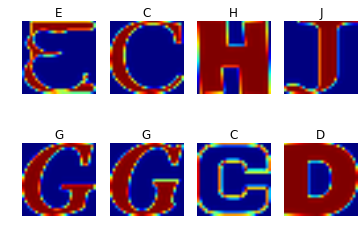

In [159]:
pred_labels = regr.predict(X_valid)
disp_sample_dataset(valid_dataset_sanit, pred_labels)

To train the model on all the data, we have to use another solver, SAG, which is a faster option.

In [160]:
regr2 = LogisticRegression(solver='sag')
sample_size = len(train_dataset)
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]
%time regr2.fit(X_train, y_train)
regr2.score(X_test, y_test)

CPU times: user 13min 42s, sys: 3.27 s, total: 13min 46s
Wall time: 13min 47s


0.87920541968079002

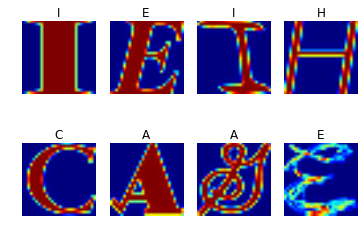

In [164]:
pred_labels = regr2.predict(X_test)
disp_sample_dataset(test_dataset_sanit, pred_labels)